**NOTA:** En la parte del cargado de la imagen tenga en cuenta ejecutar solo una de las dos opciones, ya sea desde google drive, diponiendo de la imagen en su almacen personal, en caso contrario cargue la imagen en el entorno de colab y ejecute la sección de "Carga de la imágen como archivo"

#**Librerias**


In [88]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from scipy import signal
import os
from skimage import io

#**Carga de la Imágen desde drive**

In [ ]:
drive.mount('/content/drive')
path_palacio = ('/content/drive/MyDrive/Colab Notebooks/IA2/Taller2/palacio.jpg')
palacio = Image.open(path_palacio)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Carga de la imágen como archivo**

In [89]:
# Para desto debemos cargar la imágen manualmente en el entorno de colab
# Luego accedemos a ella así
# Se debe copiar la ruta de la imagen en la variable 'path_img'
path_palacio = os.path.join('/content/', 'palacio.jpg')
path_mujer = os.path.join('/content/', 'mujer.jpg')

palacio = io.imread(path_palacio)
mujer = io.imread(path_mujer)

##**Visualización y caracteristicas de la imágen**

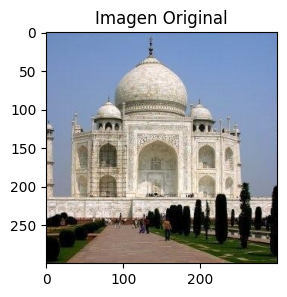

In [90]:
plt.figure(figsize=(3, 3))
plt.imshow(palacio)
plt.title("Imagen Original")
plt.show()

###**Caracteristicas de la imágen**

In [91]:
palacioimg = Image.open('/content/palacio.jpg')

La imagén original está en formato JPEG

In [92]:
palacioimg.format

'JPEG'

Es RGB y tiene dimensiones de 3840x3840

In [93]:
print(palacioimg.size)
print(palacioimg.mode)

(300, 300)
RGB


#**Pre-procesado de la imágen**



In [94]:
# Conversión de la imágen a tensor y normalizado
tensor_palacio = tf.convert_to_tensor(np.array(palacio) / 255.0, dtype=tf.float32)

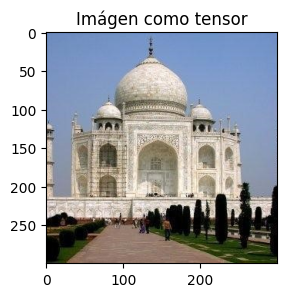

In [95]:
plt.figure(figsize=(3, 3))
plt.imshow(tensor_palacio)
plt.title("Imágen como tensor")
plt.show()

In [96]:
# Converción de la imagen a escala de grises
gray_palacio = tf.image.rgb_to_grayscale(tensor_palacio)

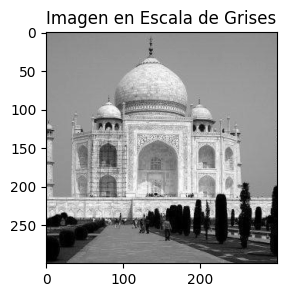

In [97]:
plt.figure(figsize=(3, 3))
plt.imshow(gray_palacio, cmap='gray')
plt.title("Imagen en Escala de Grises")
plt.show()

En el caso de la imagen en escala de grises con un previo pre-procesado con la librería tensorflow podemos observar que se trata de una matriz con dimensiones de 3840x3840

In [98]:
gray_palacio.shape

TensorShape([300, 300, 1])

Caso contrario con la imagen RGB preprocesada con tensorflow, en la cual podemos ver que se trata de un tensor de 3 capas, cada una de 3840x3840

In [99]:
tensor_palacio.shape

TensorShape([300, 300, 3])

#**Convoluciones y Kernels**

##**Solución funcional**

In [100]:
def Aplicar_convolucion(imagen, kernel):

  imagen_list = []
  for d in range(3):
    temp = signal.convolve2d(imagen[:,:,d] , kernel,  boundary='symm',mode='same')
    imagen_list.append(temp)

  imagen_filt = np.stack(imagen_list, axis=2)
  imagen_filt[imagen_filt > 255] = 255
  imagen_filt[imagen_filt < 0] = 0
  imagen_filt = imagen_filt.astype("uint8")

  plt.figure()
  plt.subplot(1,2,1)
  plt.title('Imágen con filtro')
  plt.imshow(imagen_filt)
  plt.axis('off')
  plt.subplot(1,2,2)
  plt.title('Imágen original')
  plt.imshow(imagen)
  plt.axis('off')
  plt.show()

###**Filtro: enfocar**

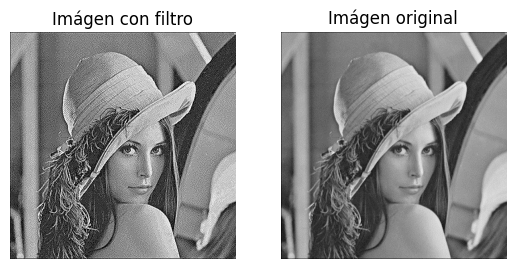

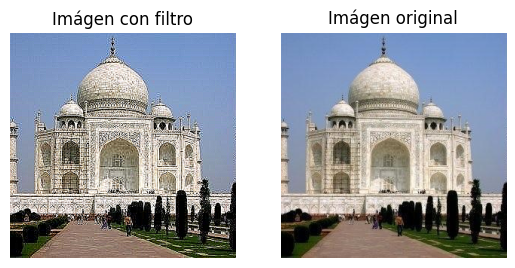

In [101]:
Kernel=np.array([[0,-1,0],
                 [-1,5,-1],
                 [0,-1,0]])
Aplicar_convolucion(mujer,Kernel)
Aplicar_convolucion(palacio,Kernel)

Con la aplicación de este filtro podemos notar que en las imágenes se hacen mucho más evidentes los detalles pequeños

###**Filtro: Desenfocar**

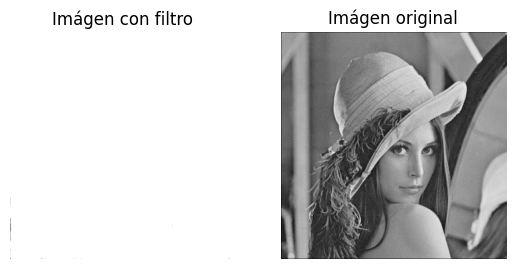

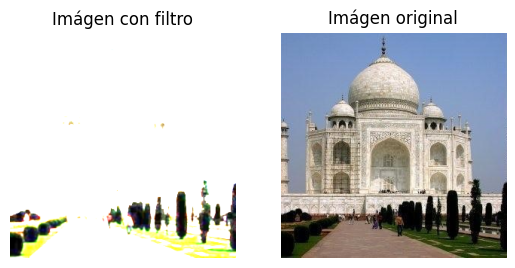

In [102]:
Kernel=np.array([[0,0,0,0,0],
                 [0,1,1,1,0],
                 [0,1,1,1,0],
                 [0,1,1,1,0],
                 [0,0,0,0,0]])

Aplicar_convolucion(mujer,Kernel)
Aplicar_convolucion(palacio,Kernel)

A causa de ser imágenes muy iluminadas podemos evidenciar que el filtro más que desenfocar, lo que hizo fue generar una especie de sobre-exposición en las imágenes

###**Filtro: Realzar Bordes**

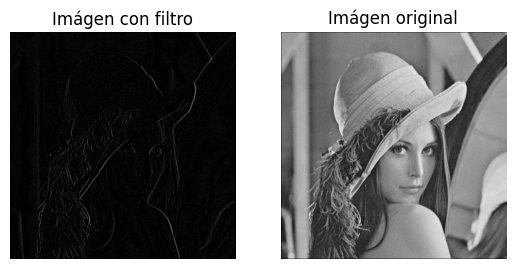

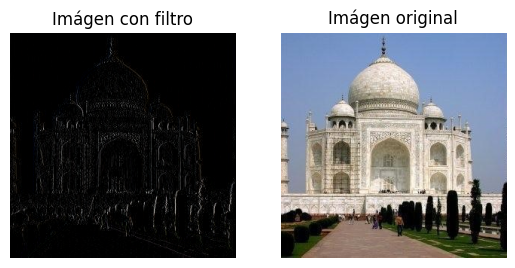

In [103]:
Kernel=np.array([[0,0,0],
                 [-1,1,0],
                 [0,0,0]])

Aplicar_convolucion(mujer,Kernel)
Aplicar_convolucion(palacio,Kernel)

Con el uso de este filtro podemos notar que es más fácil visualizar los bordes de las siluetas y contornos presentes en las imágenes

###**Filtro: Detectar bordes**

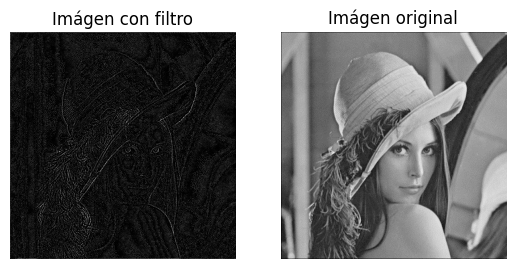

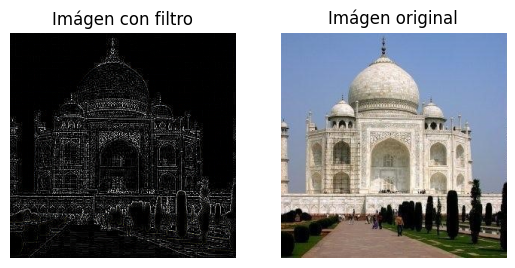

In [104]:
Kernel=np.array([[0,1,0],
                 [1,-4,1],
                 [0,1,0]])

Aplicar_convolucion(mujer,Kernel)
Aplicar_convolucion(palacio,Kernel)

A diferencia del anterior, este filtro lo que logró fue hacer visibles la gran mayoria de líneas presentes en las imágenes facilitando su identificación

###**Filtro: Repujado**

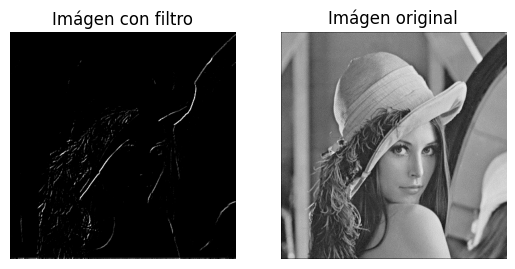

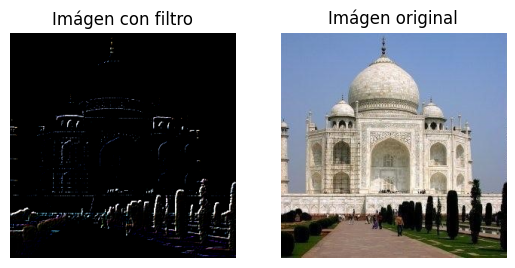

In [105]:
Kernel=np.array([[-2,-1,0],
                 [-1,1,1],
                 [0,1,0]])

Aplicar_convolucion(mujer,Kernel)
Aplicar_convolucion(palacio,Kernel)

Con la aplicación de este filtro es visible y más fácil persivir la profundidad de los objetos en las imágenes, algo así como si tuvieran efecto de relieve

##**Convoluciones con TensorFlow**
Pendiente de revisar y corregir


In [30]:
def aplicar_convolucion(imagen, Kernel):

    imagen = tf.convert_to_tensor(imagen, dtype=tf.float32)
    kernel = tf.convert_to_tensor(kernel, dtype=tf.float32)

    imagen = tf.expand_dims(imagen, axis=0)

    full_palacio = []

    for d in range(3):
      convolucion = tf.nn.conv2d(imagen[:,:,:,d], kernel, strides=[1, 1, 1, 1], padding="SAME")
      full_palacio.append(convolucion)
    full_palacio = tf.squeeze(full_palacio)

    full_palacio = tf.clip_by_value(full_palacio, 0.0, 255.0)
    full_palacio = tf.cast(full_palacio, dtype=tf.uint8)

    return full_palacio

#Definición del Kernel
kernel = tf.constant([[[[1, 1, 1],
                        [1, 1, 1],
                        [1, 1, 1]]]], dtype=tf.float32)
# Llamado de la función
imagen_convolucionada = aplicar_convolucion(palacio, kernel)

# Muestra la imagen original y la imagen después de la convolución
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(tensor_palacio)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Imagen Después de la Convolución')
plt.imshow(imagen_convolucionada)
plt.axis('off')

plt.show()


(1, 3840, 3840, 3)


InvalidArgumentError: ignored